# Random Forest and noise variables -- pics in notes

As random forest looks at only a subset of the features for each split (for classification, typically $\sqrt{d}$, where $d$ is the number of features), noise variables may have a detrimental effect. Let's check!

In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("lecture.mplstyle")
from sklearn.datasets import make_moons
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import zero_one_loss
import pandas as pd
import seaborn as sns
#plt.style.use("seaborn-v0_8")

Two imports of note here: pandas, a library to handle data in tabular form, and seaborn, a library for nice looking statistical plots.

We generate a toy data set in two dimensions. We choose a large test set so that the test error will be close to the true error.

<Figure size 600x600 with 0 Axes>

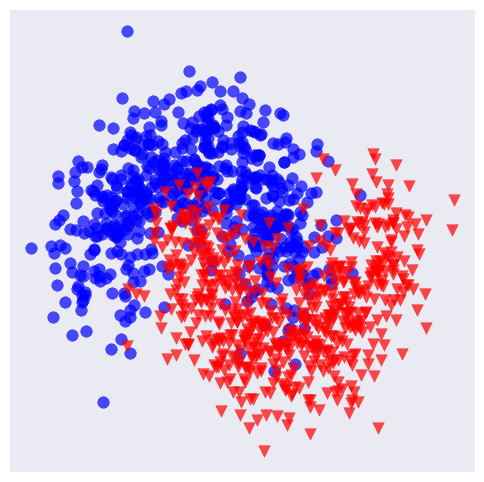

In [2]:
train_size=200
test_size=1000
X,y=make_moons(n_samples=train_size+test_size,noise=0.3) ## make_moons generates a toy dataset, see https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html

plt.figure(figsize=(6,6))
_,ax=plt.subplots(figsize=(6,6))
ax.scatter(X[y==0,0],X[y==0,1],color='blue',marker='o',s=70,alpha=0.7)
ax.scatter(X[y==1,0],X[y==1,1],color='red',marker='v',s=70,alpha=0.7)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Now, we add noise variables (features) to the training and test set. That is, we generate random noise and simply add it to the data set. Clearly, these noise features do not help to distinguish the two classes. We now fit and evaluate a random forest classifier for different numbers of noise variables, where we repeat each fit 100 times to gain some statistical stability. We also compare with AdaBoost. 

Note how we keep track of the results: we simply record all the parameters of the experiment and append this record to a list. Because it's nicer to handle we turn this list into Pandas DataFrame.

In [6]:
import time 

n_estimators=100
noise_sizes=range(10,201,10)

try:
    result=pd.read_csv("rf_noise_vars.csv")
except:
    start=time.time()
    rf=RandomForestClassifier(n_estimators=n_estimators)
    ada=AdaBoostClassifier(n_estimators=n_estimators)
    
    
    def get_errors(classifier,X,y,train_size):
        X_train,X_test=X[:train_size],X[train_size:]
        y_train,y_test=y[:train_size],y[train_size:]
        classifier.fit(X_train,y_train)
        train_err=zero_one_loss(y_train,classifier.predict(X_train))
        test_err=zero_one_loss(y_test,classifier.predict(X_test))
        return train_err,test_err
    
    noise_sizes=range(10,201,10)
    result_table=[]
    repeats=100
    for noise_size in noise_sizes:
        size=(X.shape[0],noise_size)
        for r in range(repeats):
            noise=np.random.normal(size=size)
            X_with_noise=np.hstack([X,noise])
            train_err_with_noise,test_err_with_noise = get_errors(rf,X_with_noise,y,train_size)
            result_table.append(['rf',r+1,noise_size,train_err_with_noise,test_err_with_noise])
            train_err_with_noise,test_err_with_noise = get_errors(ada,X_with_noise,y,train_size)
            result_table.append(['ada',r+1,noise_size,train_err_with_noise,test_err_with_noise])
    
    result=pd.DataFrame(result_table,columns=['algorithm','repeat_num','#noise vars','train error','test error'])

    print("total running time: {:.2f}s".format(time.time()-start))
    # let's save the data as it takes a while to compute it
    result.to_csv("rf_noise_vars.csv",index=False)

Let's have a peek at the resulting table:

In [7]:
result.head()

,algorithm,repeat_num,#noise vars,train error,test error
0,rf,1,10,0.0,0.112
1,ada,1,10,0.0,0.135
2,rf,2,10,0.0,0.130
3,ada,2,10,0.0,0.168
4,rf,3,10,0.0,0.127


In [5]:
result['train error'].max()

0.0

Aha, every instance of random forest and AdaBoost was able to fit the training set perfectly.

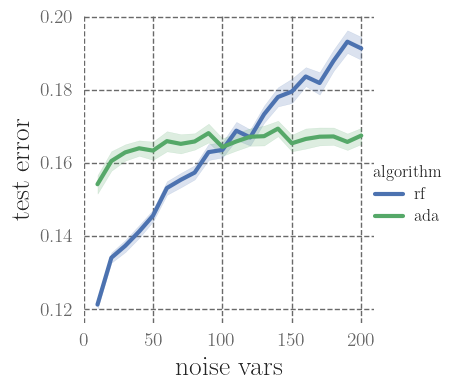

In [22]:
g=sns.relplot(x="noise vars",y="test error",kind="line",data=result.rename(columns={"#noise vars":"noise vars"}),hue='algorithm',height=4)
plt.setp(g._legend.get_texts(), fontsize='12') # for legend text
plt.setp(g._legend.get_title(), fontsize='12') # for legend title
plt.xticks([0,50,100,150,200])
plt.savefig("rf_noise_vars.png",dpi=300,bbox_inches='tight',pad_inches=0.1)